#The stakeholders want to know the average time spent per day. However, the major problem is that we do not have a well-identified session end event. Thus, we need to come up with a method of identifying the session end.

#1. Create a DataFrame for the raw_event table.

In [1]:
# Import necessary libraries
from google.colab import auth
from google.cloud import bigquery
import pandas as pd

# Authenticate the user with Google Colab
auth.authenticate_user()

# Set the Google Cloud project ID
project_id = 'tc-da-1'

# Create a BigQuery client
client = bigquery.Client(project=project_id)

# Specify the dataset and get its reference
dataset_ref = client.dataset("turing_data_analytics", project=project_id)
dataset = client.get_dataset(dataset_ref)

# List tables in the dataset and select the third table
tables = list(client.list_tables(dataset))
table_id = tables[2].table_id

# Formulate the SQL table ID for querying
sql_table_id = f'{project_id}.turing_data_analytics.{table_id}'

# Query the specified BigQuery table and convert the result to a DataFrame
raw_data = client.list_rows(sql_table_id).to_dataframe()

# Display the first few rows of the DataFrame
raw_data.head()


,event_date,event_timestamp,event_name,event_value_in_usd,user_id,user_pseudo_id,user_first_touch_timestamp,category,mobile_model_name,mobile_brand_name,...,purchase_revenue_in_usd,refund_value_in_usd,shipping_value_in_usd,tax_value_in_usd,transaction_id,page_title,page_location,source,page_referrer,campaign
0,20201115,1605430896492843,user_engagement,NaN,None,13445036.7517695097,1605430699590658,mobile,Pixel 4 XL,Google,...,NaN,NaN,NaN,NaN,None,Google Online Store,https://googlemerchandisestore.com/,google,None,<Other>
1,20201222,1608662972374077,scroll,NaN,None,78222512.5114977021,1608662850418789,mobile,Pixel 4 XL,Google,...,NaN,NaN,NaN,NaN,None,The Google Merchandise Store - My Account,https://shop.googlemerchandisestore.com/myacco...,shop.googlemerchandisestore.com,https://shop.googlemerchandisestore.com/myacco...,(referral)
2,20210128,1611793340716086,page_view,NaN,None,19512607.6484939990,1611793336236527,mobile,Pixel 4 XL,Google,...,NaN,NaN,NaN,NaN,None,Home,https://shop.googlemerchandisestore.com/store....,None,None,None
3,20201214,1607912184230367,user_engagement,NaN,None,71934961.8102506801,1607912180933587,mobile,Pixel 4 XL,Google,...,NaN,NaN,NaN,NaN,None,Home,https://shop.googlemerchandisestore.com/,None,None,None
4,20201103,1604382285906806,user_engagement,NaN,None,6016153.5120427538,1600131664218605,mobile,Pixel 3,Google,...,NaN,NaN,NaN,NaN,None,Home,https://shop.googlemerchandisestore.com/,googlemerchandisestore.com,None,(referral)


#2. The session start can be one of two things: the first event or session start. Thus, we will take the earliest event time from these two for a given day and a given person. The session end can be anything except events in the session end category. Therefore, we will take the latest event for a given day and a given person. We will also extract additional information, merge the tables, convert Epoch time, and calculate the time difference in minutes.

In [ ]:
# Filter data for the first and end events
filtered_data_for_first_event = raw_data[(raw_data['event_name'].isin(['first_visit', 'session_start']))]
filtered_data_for_end_event = raw_data[(raw_data['event_name'] != 'first_visit') & (raw_data['event_name'] != 'session_start')]

# Extract relevant columns for the start and end events
start = filtered_data_for_first_event[['event_date', 'user_pseudo_id', 'event_timestamp']]
end = filtered_data_for_end_event[['event_date', 'user_pseudo_id', 'event_timestamp', 'category', 'mobile_brand_name', 'campaign']]

# Find the minimum event timestamp for each user for the start events
min_start = start.groupby(['event_date', 'user_pseudo_id']).agg({'event_timestamp': 'min'}).reset_index()

# Find the maximum event timestamp and associated details for each user for the end events
max_end = end.groupby(['event_date', 'user_pseudo_id']).agg({
    'event_timestamp': 'max',
    'category': 'first',
    'mobile_brand_name': 'first',
    'browser': 'first',
    'campaign': 'first'
}).reset_index()

# Merge the start and end event data based on event date and user pseudo ID
joined_data = max_end.merge(min_start, how='inner', on=['event_date', 'user_pseudo_id'], suffixes=('_end', '_start'))

# Convert event timestamps to datetime format
joined_data['event_timestamp_end'] = pd.to_datetime(joined_data['event_timestamp_end'], unit='us')
joined_data['event_timestamp_start'] = pd.to_datetime(joined_data['event_timestamp_start'], unit='us')

# Calculate time spent in minutes
joined_data['time_spent'] = round((joined_data['event_timestamp_end'] - joined_data['event_timestamp_start']).dt.total_seconds() / 60, 2)

# Format event date to a more readable format
joined_data['event_date'] = pd.to_datetime(joined_data['event_date'], format='%Y%m%d').dt.strftime('%Y-%m-%d')

# Display the final joined and processed data
joined_data


,event_date,user_pseudo_id,event_timestamp_end,category,mobile_brand_name,browser,campaign,event_timestamp_start,time_spent
0,2020-11-01,10054495.7553807982,2020-11-01 14:38:05.827188,desktop,<Other>,<Other>,(referral),2020-11-01 14:37:36.516750,0.49
1,2020-11-01,1005694.5834348403,2020-11-01 00:54:42.302672,desktop,Google,Chrome,None,2020-11-01 00:54:33.036492,0.15
2,2020-11-01,10109323.0077737427,2020-11-01 03:27:25.357583,desktop,Google,Chrome,(referral),2020-11-01 03:25:03.890514,2.36
3,2020-11-01,1013442.5000387623,2020-11-01 03:52:47.912125,mobile,Samsung,Chrome,(referral),2020-11-01 03:52:23.751333,0.40
4,2020-11-01,1014060.1100191558,2020-11-01 20:27:24.780019,desktop,Apple,Chrome,<Other>,2020-11-01 20:26:54.447559,0.51
...,...,...,...,...,...,...,...,...,...
314328,2021-01-31,97891114.5285344430,2021-01-31 22:34:53.602819,mobile,Apple,Safari,None,2021-01-31 22:34:48.580244,0.08
314329,2021-01-31,98254560.4107479768,2021-01-31 10:07:40.735033,mobile,Xiaomi,Chrome,(organic),2021-01-31 10:07:27.445628,0.22
314330,2021-01-31,98259410.9787095828,2021-01-31 11:05:57.469965,mobile,Apple,Chrome,(referral),2021-01-31 10:11:20.596736,54.61
314331,2021-01-31,98369441.0314911723,2021-01-31 23:24:43.764529,desktop,Apple,Chrome,None,2021-01-31 23:24:40.231228,0.06


#3. Convert the date into day names, aggregate everything into an average, and group by the day name.

In [ ]:
# Extract the day name from the event date and add it to the joined data
joined_data['day_name'] = pd.to_datetime(joined_data['event_date']).dt.day_name()

# Extract relevant columns for aggregation
aggregated_data = joined_data[['day_name', 'time_spent']]

# Group by day name and calculate the mean time spent for each day
aggregated_data = aggregated_data.groupby(['day_name']).agg({'time_spent': 'mean'}).reset_index()

# Display the aggregated result
aggregated_data


,day_name,time_spent
0,Friday,29.959477
1,Monday,28.156016
2,Saturday,25.632562
3,Sunday,24.520849
4,Thursday,30.715336
5,Tuesday,31.771382
6,Wednesday,31.348489


#4. Create a bar chart that will show the average time spent per day based on all campaigns.

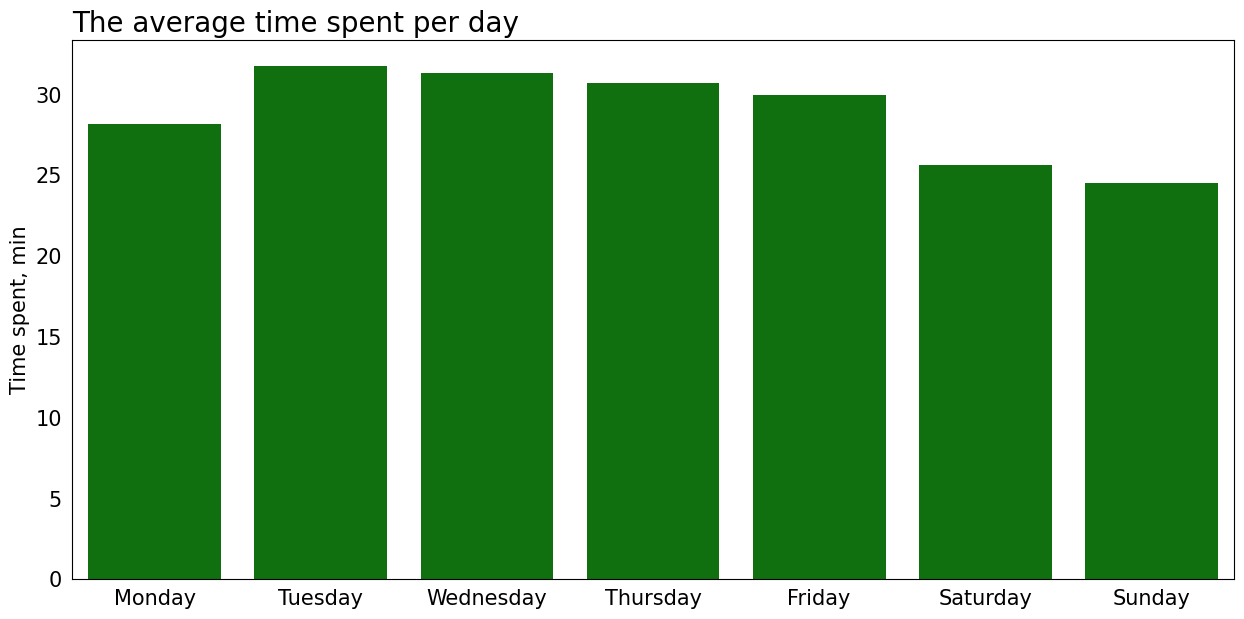

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the size of the plot
plt.figure(figsize=(15, 7))

# Create a bar plot using seaborn
sns.barplot(
    data=aggregated_data,
    x='day_name',
    y='time_spent',
    order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    color='green',
    linewidth=3
)

# Set plot title and labels
plt.title('The average time spent per day', loc='left', size=20)
plt.xlabel('')
plt.ylabel('Time spent, min', size=15)

# Set tick parameters
plt.tick_params(labelsize=15, left=False, bottom=False)

#5. Create a bar chart that will show the average time spent per day, grouped by campaign.

In [ ]:
# Extract the day name from the event date and add it to the joined data
joined_data['day_name'] = pd.to_datetime(joined_data['event_date']).dt.day_name()

# Extract relevant columns for aggregation (use correct variable name)
aggregated_data_campaign = joined_data[['day_name', 'time_spent', 'campaign']]

# Group by day name and campaign, then calculate the mean time spent for each combination
aggregated_data_campaign = aggregated_data_campaign.groupby(['day_name', 'campaign']).agg({'time_spent': 'mean'}).reset_index()

# Display the aggregated result
aggregated_data_campaign


,day_name,campaign,time_spent
0,Friday,(data deleted),28.320354
1,Friday,(direct),40.050958
2,Friday,(organic),22.271298
3,Friday,(referral),47.802040
4,Friday,<Other>,26.059117
...,...,...,...
59,Wednesday,<Other>,28.851672
60,Wednesday,BlackFriday_V2,0.010000
61,Wednesday,Data Share Promo,95.103226
62,Wednesday,NewYear_V1,4.308571


#6. Since we have several versions of the same campaign, and V1 was live for a shorter period than V2, we have decided to exclude V1. This is because it would generate very small numbers compared to other campaigns. Additionally, the database is quite chaotic, and many rows of interest have been deleted, so we can expect a very chaotic graph.

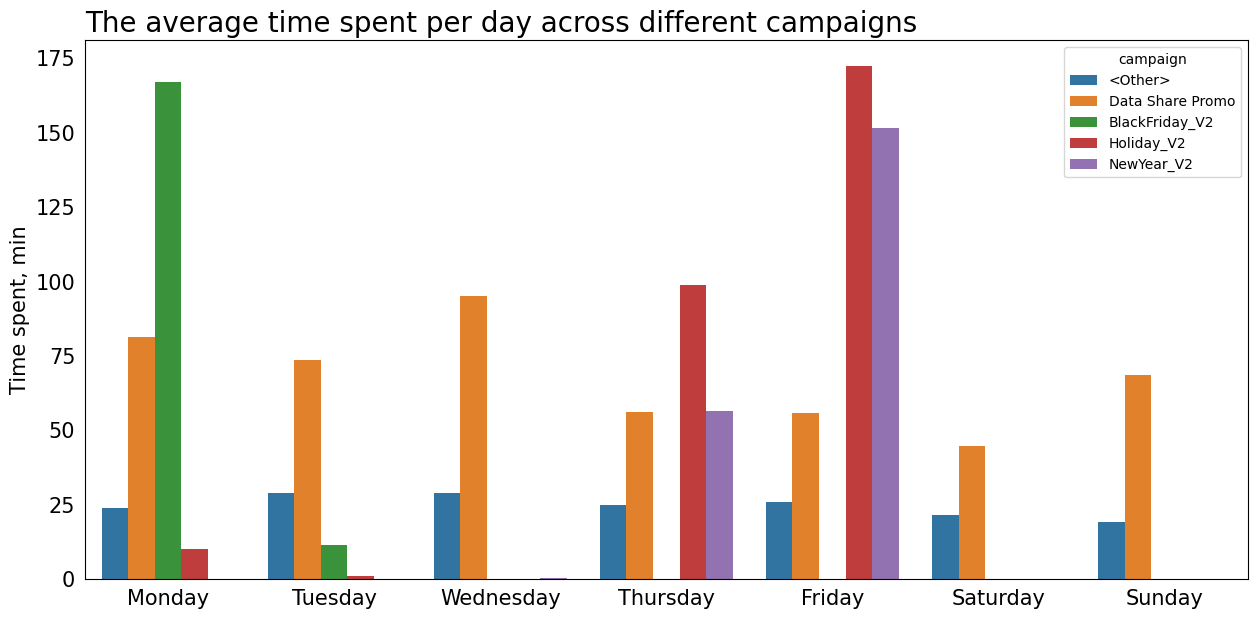

In [ ]:
# Set the size of the plot
plt.figure(figsize=(15, 7))

# Campaigns to exclude from the plot
campaigns_to_exclude = ['(data deleted)', '(direct)', '(referral)', '(organic)', 'NewYear_V1', 'Holiday_V1', 'BlackFriday_V1']

# Filter out excluded campaigns
filtered = aggregated_data_campaign[~aggregated_data_campaign['campaign'].isin(campaigns_to_exclude)]

# Create a bar plot using seaborn, showing time spent per day across different campaigns
sns.barplot(
    data=filtered,
    x='day_name',
    y='time_spent',
    order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    errorbar=None,
    hue='campaign',
    linewidth=3
)

# Set plot title and labels
plt.title('The average time spent per day across different campaigns', loc='left', size=20)
plt.xlabel('')
plt.ylabel('Time spent, min', size=15)

# Set tick parameters
plt.tick_params(labelsize=15, left=False, bottom=False)

#7. We can also look at the difference in experience and time spent on different devices.

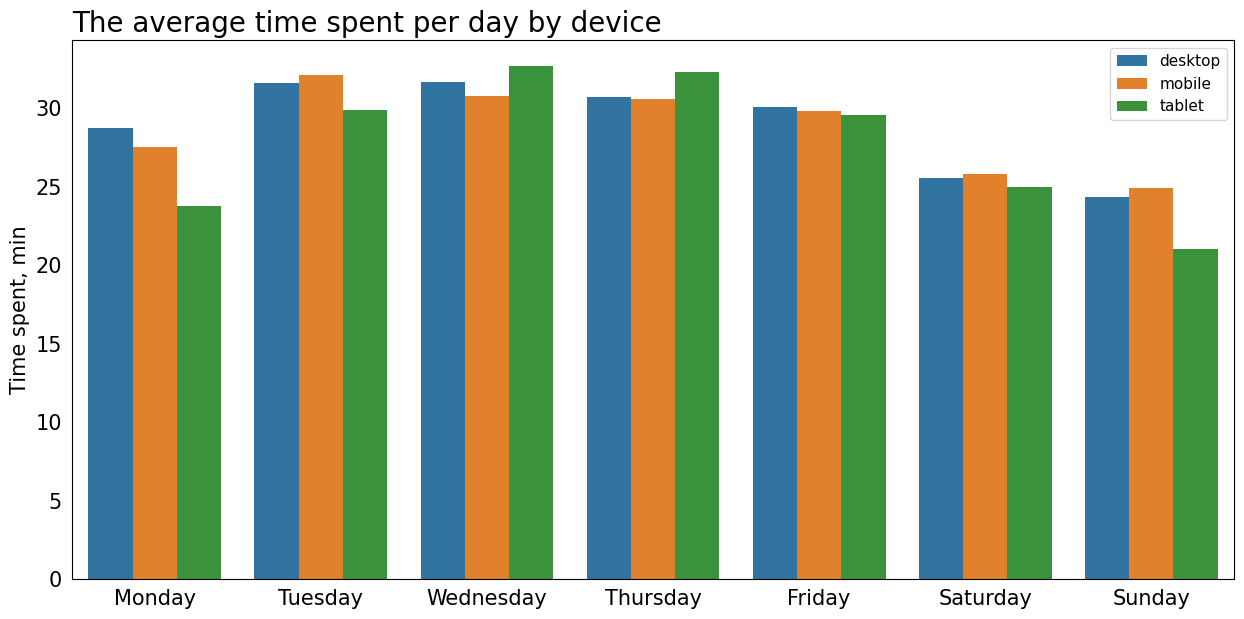

In [ ]:
# Extract relevant columns for aggregation
joined_data_category = joined_data[['day_name', 'time_spent', 'category']]

# Group by day name and category, then calculate the mean time spent for each combination
joined_data_category = joined_data_category.groupby(['day_name', 'category']).agg({'time_spent': 'mean'}).reset_index()

# Set the size of the plot
plt.figure(figsize=(15, 7))

# Create a bar plot using seaborn, showing time spent per day across different categories
sns.barplot(
    data=joined_data_category,
    x='day_name',
    y='time_spent',
    order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    hue='category',
    linewidth=3
)

# Set plot title and labels
plt.title('The average time spent per day by device', loc='left', size=20)
plt.xlabel('')
plt.ylabel('Time spent, min', size=15)
plt.legend(fontsize='11', loc='upper right')

# Set tick parameters
plt.tick_params(labelsize=15, left=False, bottom=False)

#8. And also different mobile brands.

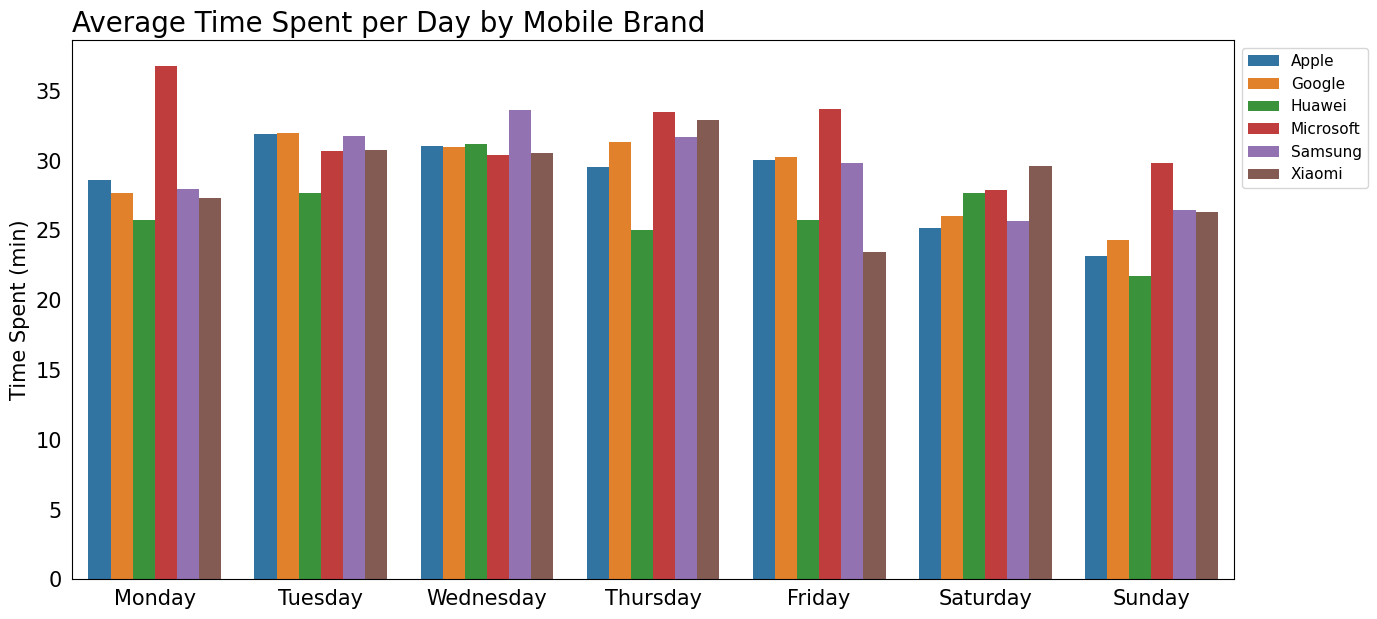

In [ ]:
# Filter data
filtered_data = joined_data[(joined_data['mobile_brand_name'] != '<Other>') & (joined_data['mobile_brand_name'] != 'Mozilla')]

# Group by 'day_name' and 'mobile_brand_name', calculate the mean of 'time_spent'
grouped_data = filtered_data.groupby(['day_name', 'mobile_brand_name']).agg({'time_spent': 'mean'}).reset_index()

# Plotting
plt.figure(figsize=(15, 7))

sns.barplot(data=grouped_data, x='day_name', y='time_spent', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], hue='mobile_brand_name', linewidth=3)

# Set plot title and labels
plt.title('Average Time Spent per Day by Mobile Brand', loc='left', size=20)
plt.xlabel('')
plt.ylabel('Time Spent, min', size=15)
plt.legend(fontsize='11', loc='upper left', bbox_to_anchor=(1, 1))

# Set tick parameters
plt.tick_params(labelsize=15, left=False, bottom=False)

#Conclusions:

#1. Users tend to spend more time on webpages in the middle of the week, with a decline starting on Wednesday (overall time spent) or Thursday (by mobile brand and devices). Although the average time spent varies between 20-30 minutes, the decrease is considered insignificant from a business model perspective.

#2. Drawing conclusions based on different campaigns is challenging due to the chaotic nature of the database, and most events on relevant campaigns have been deleted.